In [ ]:
#A Basic Collaborative Filtering based recommendation system.

In [1]:
#Mandatory Imports
import os
os.chdir('F:\\DS_Material\\01_2019_DS\\Datasets\\books')
#os.chdir('F:\\DS_Material\\01_2019_DS\\Datasets\\goodbooks-10k-master')

%matplotlib inline
import pandas as pd
import numpy as np
from numpy import int64

import requests
import IPython.display as Disp

import sklearn
from sklearn.decomposition import TruncatedSVD

In [2]:
books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv", encoding='UTF-8', dtype={'user_id': int,'book_id':int,
'rating':int} )

In [3]:
print(books.head())
print(ratings.head())

   id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   3    41865         41865  3212258          226  316015849  9.780316e+12   
3   4     2657          2657  3275794          487   61120081  9.780061e+12   
4   5     4671          4671   245494         1356  743273567  9.780743e+12   

                       authors  original_publication_year  \
0              Suzanne Collins                     2008.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   
2              Stephenie Meyer                     2005.0   
3                   Harper Lee                     1960.0   
4          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0                          The Hunger Games  ...       4780653   
1  Harry Potter and the Ph

In [4]:
print(books.shape)
print(ratings.shape)

(10000, 23)
(981756, 3)


In [5]:
print(books.info())
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
id                           10000 non-null int64
book_id                      10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
books_count                  10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

In [6]:
books_df = books[['book_id', 'books_count', 'original_publication_year',
'average_rating','original_title','image_url','authors']]
books_df.head()

,book_id,books_count,original_publication_year,average_rating,original_title,image_url,authors
0,2767052,272,2008.0,4.34,The Hunger Games,https://images.gr-assets.com/books/1447303603m...,Suzanne Collins
1,3,491,1997.0,4.44,Harry Potter and the Philosopher's Stone,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
2,41865,226,2005.0,3.57,Twilight,https://images.gr-assets.com/books/1361039443m...,Stephenie Meyer
3,2657,487,1960.0,4.25,To Kill a Mockingbird,https://images.gr-assets.com/books/1361975680m...,Harper Lee
4,4671,1356,1925.0,3.89,The Great Gatsby,https://images.gr-assets.com/books/1490528560m...,F. Scott Fitzgerald


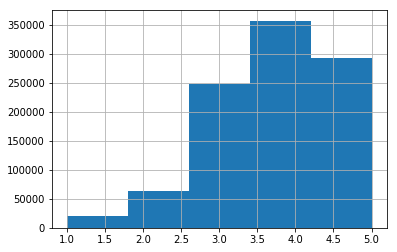

In [7]:
ratings.rating.hist(bins=5)

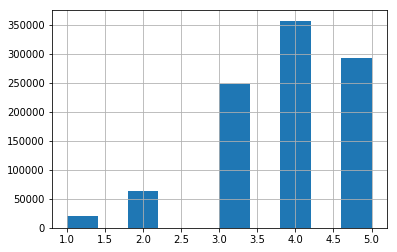

In [8]:
ratings.rating.hist(bins=10)

In [9]:
ratings.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [10]:
ratings.groupby('user_id')['rating'].count()

user_id
1         3
2         3
3         2
4         3
5         5
6         2
7        76
8         3
9         7
10       16
11        9
12        2
13        2
14        5
15        2
16        7
17        2
18        6
19       24
20        3
21        4
22       19
23       42
24       17
25       13
26        3
27       28
28        5
29        7
30        2
         ..
53395     3
53396     6
53397     4
53398     7
53399     4
53400    14
53401    45
53402     2
53403    44
53404     4
53405     7
53406     4
53407     7
53408     2
53409    28
53410     2
53411    21
53412     2
53413    24
53414     8
53415     3
53416     2
53417     3
53418     3
53419     6
53420     6
53421     8
53422    18
53423     2
53424    16
Name: rating, Length: 53424, dtype: int64

In [11]:
# Merge books and ratings dataset
books_ratings = pd.merge(ratings,books,on='book_id')
books_ratings.head()

,book_id,user_id,rating,id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,314,5,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,439,3,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,588,5,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,1169,4,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,1185,4,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",...,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [12]:
books_ratings.shape

(79701, 25)

In [13]:
books_ratings.groupby('book_id')['rating'].count().sort_values(ascending=False)

book_id
5107    100
3750    100
3711    100
3710    100
3698    100
3692    100
3690    100
3686    100
3685    100
3682    100
3679    100
3656    100
3648    100
3636    100
3590    100
3586    100
3581    100
3579    100
3562    100
3507    100
3483    100
3478    100
3476    100
3717    100
3757    100
5166    100
3758    100
3977    100
3974    100
3973    100
       ... 
9742     86
7628     85
9865     85
8248     84
9328     84
9570     83
9598     83
9590     81
9530     80
9014     80
9913     78
9301     78
9375     77
7144     76
7661     76
6572     76
9646     75
9838     74
5413     74
5038     73
9416     71
9531     70
7677     69
5053     68
8948     61
6819     60
9762     60
9418     59
8964     59
9534     57
Name: rating, Length: 812, dtype: int64

In [14]:
books_ratings_ct = books_ratings.pivot_table(values='rating',index='user_id',columns='original_title',fill_value=0)
books_ratings_ct.head()

original_title,,Animal Farm & 1984,Carter Beats the Devil,The Fellowship of the Ring,"めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]",'Salem's Lot The Illustrated Edition,'Tis: A Memoir,1421: The Year China Discovered America,1776,31 Songs,...,Ἰλιάς ; Ὀδύσσεια,Ἰστορίαι,Ὀδύσσεια,Ὀρέστεια,…trotzdem Ja zum Leben sagen: Ein Psychologe erlebt das Konzentrationslager,スプートニクの恋人 [Supūtoniku no Koibito],海辺のカフカ [Umibe no Kafuka],砂の女 [Suna no onna],象の消滅 [Zō no shōmetsu],鋼の錬金術師 1
user_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,0
9,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
books_ratings_ct.shape#28554,794

(28554, 794)

In [17]:
#If we take a look at the shape of the books_ratings_ct
#28554 userids----rows
#794 book titles--------columns
#If we try to get the Pearsons correlation matrix with these dimensions,
#it will be computationally very high and not feasible.
#Hence, we need to do dimensionality reduction by using SingleValueDecomposition.
#But the TruncatedSVD class performs decomposition only on columns.
#Here, we have book titles as columns which we want to retain for recommending.
#Whereas userids can be reduced for better efficiency.
#Using transpose, interchange rows to columns and vice versa.
#Then apply SVD.

print(type(books_ratings_ct.T))
X = books_ratings_ct.values.T
X.shape

<class 'pandas.core.frame.DataFrame'>


(794, 28554)

In [19]:
# Compress dataset by applying Singular Value Decomposistion (SVD)
# BAsically, SVD is a dimensionality reduction technique which reduces dimensions by trying to 
#categorize them and without losing the significance of important features.
#At core, its a linear algebra method that decompose a sparse utility matrix into three
#compressed matrices.
SVD = TruncatedSVD(n_components=20,random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(794, 20)

In [20]:
# Create Pearson coorelation matrix
corr_mat = np.corrcoef(result_matrix)
corr_mat.shape

(794, 794)

In [21]:
type(corr_mat)

numpy.ndarray

In [22]:
corr_mat[0]

array([ 1.        ,  0.14722017,  0.05981096, -0.07895347,  0.59859182,
        0.22691538, -0.02408682, -0.19145106, -0.0820406 , -0.05326794,
        0.32776489,  0.00308409,  0.8474745 , -0.07912141,  0.08412   ,
        0.660428  ,  0.18052024,  0.55392146,  0.67623043,  0.23834482,
        0.02935062,  0.86085815,  0.48397267,  0.22877151, -0.05068203,
        0.08398955,  0.34599868,  0.2104644 ,  0.45933318,  0.32640715,
        0.19445527,  0.27994297,  0.04162444,  0.02978464,  0.29628125,
        0.62603243,  0.18755142,  0.2044494 , -0.01795574, -0.01983138,
        0.09351939,  0.36096722,  0.38081356,  0.58456643,  0.11038776,
        0.52077856,  0.04534454, -0.0666606 ,  0.11141464,  0.6099997 ,
        0.35911586,  0.91118749,  0.58865177,  0.01018069, -0.04014816,
        0.52801292,  0.26754058,  0.48877385,  0.29809543,  0.35363152,
       -0.07438237,  0.41482321, -0.29674132,  0.80060111,  0.86527979,
        0.7604578 ,  0.01248991, -0.08994772,  0.17012727,  0.24

In [23]:
corr_mat[1,]

array([ 1.47220168e-01,  1.00000000e+00,  2.91110111e-01,  1.65504165e-01,
        5.08328922e-01,  5.00937454e-01,  5.55964350e-01,  3.95298713e-01,
        1.11328145e-01,  2.19533406e-01,  6.37186188e-01,  1.62991505e-01,
        9.97369750e-02,  1.26778752e-01,  4.01539728e-01,  7.29605215e-02,
        4.65016502e-01,  3.43741741e-01,  4.45588125e-01,  4.39353597e-01,
        6.47764435e-01,  3.89011912e-01,  4.94716382e-01,  2.05758043e-01,
        2.03196469e-01,  4.78644584e-01,  3.04739525e-02,  5.38661029e-01,
       -2.35811854e-02,  3.45215894e-01, -1.78669370e-01,  8.90005647e-01,
        3.02618735e-01,  1.50428333e-01,  6.12007244e-01,  3.02182328e-01,
        6.82434247e-01,  6.57760536e-01,  3.16117437e-01,  1.46223244e-01,
        4.96285755e-02,  2.47023699e-01,  5.69659322e-01,  2.48423517e-02,
        5.44061737e-01,  6.57341097e-01,  3.81432591e-01,  5.65335789e-01,
        1.98107954e-01,  2.09403363e-01,  1.59683078e-01,  8.70240977e-02,
        7.71547487e-02,  

In [25]:
# Print list of books
book_names=books_ratings_ct.columns
book_list = list(book_names)
book_list

[' ',
 ' Animal Farm & 1984',
 ' Carter Beats the Devil',
 ' The Fellowship of the Ring',
 ' めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]',
 "'Salem's Lot The Illustrated Edition",
 "'Tis: A Memoir",
 '1421: The Year China Discovered America',
 '1776',
 '31 Songs',
 'A Bend in the River',
 'A Bend in the Road',
 'A Brief History of Time: From the Big Bang to Black Holes',
 'A Briefer History of Time',
 'A Case of Need',
 'A Christmas Carol',
 'A Christmas Carol and Other Christmas Writings',
 'A Fine Balance',
 'A Great and Terrible Beauty',
 'A Heartbreaking Work of Staggering Genius',
 'A History of God: The 4,000-Year Quest of Judaism, Christianity, and Islam',
 'A History of the World in 6 Glasses',
 'A Home at the End of the World',
 'A House for Mr. Biswas',
 'A Lesson Before Dying',
 'A Little Princess',
 'A Man Without a Country',
 'A Map of the World',
 "A Midsummer Night's Dream",
 'A Million Little Pieces',
 'A Modest Proposal and Other Satirical Works',
 'A Moveable Feast',
 

In [30]:
def printRecommendedBooks(bookName):
    bookNameIndex = book_list.index(bookName)
    corrBookName = corr_mat[bookNameIndex]
    filterThreshold = (corrBookName<1.0) & (corrBookName>0.8)
    return list(book_names[filterThreshold])

In [31]:
printRecommendedBooks("Plum Lovin'")

['A House for Mr. Biswas',
 "A People's History of the United States: 1492 to Present ",
 'Dreamland ',
 'Ensaio Sobre a Cegueira',
 'Founding Brothers: The Revolutionary Generation',
 'Franny and Zooey',
 'Freak the Mighty',
 "Jewel (Oprah's Book Club) ",
 'On Beauty',
 'Persepolis 2 ',
 'Shopaholic Abroad',
 'Sickened',
 'The Blank Slate: The Modern Denial of Human Nature',
 'The Lorax',
 'The Lost World',
 'We Were the Mulvaneys']

In [32]:
printRecommendedBooks('A Christmas Carol')

['Middlesex', 'Night over Water', 'O Diário de um Mago', 'Persuasion']

In [33]:
printRecommendedBooks('The Fountainhead')

['Sunshine',
 'The Audacity of Hope: Thoughts on Reclaiming the American Dream',
 'The Call of the Wild',
 'The Innocent Man',
 'The Life and Strange Surprising Adventures of Robinson Crusoe of York, Mariner',
 'The Long Goodbye',
 'The Woman in White',
 'Война и миръ',
 '…trotzdem Ja zum Leben sagen: Ein Psychologe erlebt das Konzentrationslager']